In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as ss

In [2]:
def plot_osc_hist(data, f, tsim, n_bins, title, multi):
    peaks = ss.find_peaks(20*np.sin(2*np.pi*(f/1000)*np.arange(0,tsim*1000,.1)))[0]

    h = np.zeros((1,n_bins))
    for i in np.arange(0,peaks.shape[0]-1):
        y = np.histogram(data['spikes']['biophysical']['timestamps'][:],
                     bins=np.linspace(np.round(peaks[i]/10),np.round(peaks[i+1]/10),n_bins))[0]
        
        if y.shape[0]<n_bins:
            # If small, pad with zero
            h+=np.concatenate((y,[0]))
        else:
            #import pdb; pdb.set_trace()
            h+=y
        
    plt.bar(np.arange(0,n_bins)+0.5,h[0]/h[0].sum())
    plt.twinx()
    plt.plot(np.cos(2*np.pi*(multi*f/1000)*np.arange(0,n_bins)),color='k')
    plt.xticks(ticks=[0,int(n_bins/2),n_bins-1],labels=['-pi','0','pi'])
    plt.title(title)
    
def voltage_criterion(data=None, v_thresh=-40, time_thresh=260):
    threshold_crossings = np.diff(data > v_thresh, prepend=False)
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    # If length of threshold_crossings is not even
    if np.mod(np.argwhere(threshold_crossings).reshape(-1,).shape[0],2)!=0:
        legit_up_crossings = upward_crossings[:-1][np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
    else:
        legit_up_crossings = upward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
    return upward_crossings, legit_up_crossings, legit_down_crossings

# Input: upward and downward crossings
# Output: bounds of NMDA spikes meeting current criterion
def current_criterion(legit_uc_iso=[], legit_dc_iso=[], p=1, control_inmda=np.array([1])):
    bounds = []
    sum_current = []
    

    for ind1 in np.arange(0,len(legit_uc_iso)):
        e1 = control_inmda[legit_uc_iso[ind1], p] #current @ up_crossing[ind1]
        #all the indices where current crosses 130% of e1
        x30 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.3*e1, prepend=False))
        #all the indices where current crosses 115% of e1
        x15 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.15*e1, prepend=False))
        
        if len(x30)>0:
        
            x15_copy = x15
            x30_copy = x30
            
            try:
                i = x30[0][0]
            except:
                import pdb; pdb.set_trace()
                
            n = 0
            
            
            while n==0:
                if len(np.sort(x15[x15>i]))!=0:
                    b1 = i
                    b2 = np.sort(x15[x15>i])[0]
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2,p])/10)
                else:
                    b1 = i
                    b2 = (legit_dc_iso[ind1]-legit_uc_iso[ind1])
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2,p])/10)
                    n=1
                
                x30_copy = x30_copy[x30_copy>legit_uc_iso[ind1]+b2]
                #import pdb; pdb.set_trace()
                
                if len(x30_copy)!=0:
                    i = x30_copy[x30_copy>b2][0]
                else:
                    n=1
    return bounds, sum_current

In [3]:
spks_control = h5py.File('./output_control/spikes.h5','r')
spks_64Hz_soma_50p = h5py.File('./output_64Hz_soma_inh/spikes.h5','r')
spks_64Hz_soma_20p = h5py.File('./output_64Hz_soma_inh_20p/spikes.h5','r')
spks_16Hz_dend_50p = h5py.File('./output_16Hz_dend_inh/spikes.h5','r')
#spks_16Hz_dend_10p = h5py.File('./output_16Hz_dend_inh_10p/spikes.h5','r')

v_control = h5py.File('./output_control/v_report.h5','r')
v_64Hz_soma_50p = h5py.File('./output_64Hz_soma_inh/v_report.h5','r')
v_64Hz_soma_20p = h5py.File('./output_64Hz_soma_inh_20p/v_report.h5','r')
v_16Hz_dend_50p = h5py.File('./output_16Hz_dend_inh/v_report.h5','r')
#v_16Hz_dend_10p = h5py.File('./output_16Hz_dend_inh_10p/v_report.h5','r')

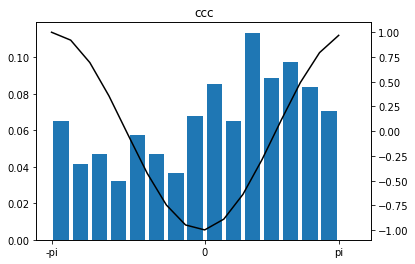

In [7]:
plot_osc_hist(data = spks_64Hz_soma_20p,
              f = 64,
              tsim = 150,
              n_bins = 16,
              title = 'ccc',
              multi = 1)

In [9]:
spks_control['spikes']['biophysical']['timestamps'][:].shape[0]/150

5.5

In [10]:
spks_64Hz_soma_50p['spikes']['biophysical']['timestamps'][:].shape[0]/150

5.8533333333333335

In [11]:
spks_64Hz_soma_20p['spikes']['biophysical']['timestamps'][:].shape[0]/150

4.52

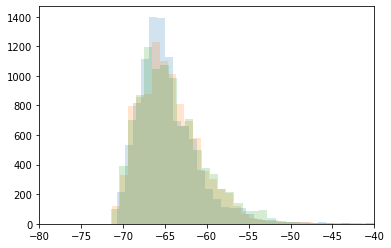

In [12]:
plt.hist(v_control['report']['biophysical']['data'][10000:20000,0],bins=100,alpha=0.2)
plt.hist(v_64Hz_soma_20p['report']['biophysical']['data'][10000:20000,0],bins=100,alpha=0.2)
plt.hist(v_64Hz_soma_50p['report']['biophysical']['data'][10000:20000,0],bins=100,alpha=0.2)
plt.xlim(-80,-40)
plt.show()

In [5]:
segs = pd.read_csv('/Volumes/TOSHIBA EXT/L5NeuronSimulation_new/L5NeuronSimulation/MorphAnalysis/Segments.csv')
segs_degrees = pd.read_csv('SegmentsDegrees.csv').groupby(['Type','Sec ID'])['Degrees'].max().reset_index()
segs['segmentID'] = segs.index
segs = segs.set_index(['Type','Sec ID']).join(segs_degrees.set_index(['Type','Sec ID'])).reset_index()

segs['Sec ID'] = segs['Sec ID'].astype(int)
segs['X'] = segs['X'].astype(float)
segs['Elec_distanceQ'] = 'None'

segs.loc[segs.Type=='dend','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='dend','Elec_distance'], 10, labels=False)
segs.loc[segs.Type=='apic','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='apic','Elec_distance'], 10, labels=False)

## Somatic spikes vs. phase of oscillation

In [14]:
# peaks for entire trace


##########################################
# plot spike timing by phase of inhibition
#peaks = ss.find_peaks(20*np.sin(2*np.pi*(64/1000)*np.arange(0,150000,.1)))[0]
#
#h = np.zeros((1,15))
#for i in np.arange(0,peaks.shape[0]-1):
#    y = np.histogram(spks_64Hz_soma['spikes']['biophysical']['timestamps'][:],
#                 bins=np.arange(np.round(peaks[i]/10),np.round(peaks[i+1]/10),1))[0]
#    if y.shape[0]<15:
#        h+=np.concatenate((y,[0]))
#    else:
#        h+=y
#        
#plt.bar(np.arange(0,15)+0.5,h[0]/h[0].sum())
#plt.plot(np.arange(0,16),0.09+0.09*np.cos(2*np.pi*(64/1000)*np.arange(0,16)),color='k')
#plt.xticks(ticks=[0,8,15],labels=['-pi','0','pi'])
#plt.title('64 Hz somatic inhibition')

In [15]:
#plot_osc_hist(data = spks_16Hz_dend_50p,
#              f = 16,
#              n_bins = 16,
#              title = '16 Hz dendritic inhibition',
#              multi=4)

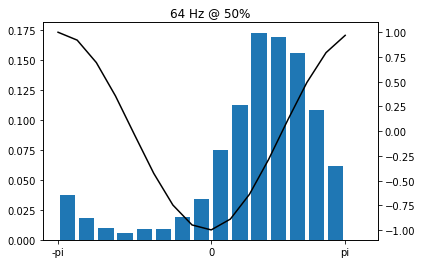

In [17]:
plot_osc_hist(data = spks_64Hz_soma_50p,
              f = 64,
              tsim = 150,
              n_bins = 16,
              title = '64 Hz @ 50%',
              multi = 1)

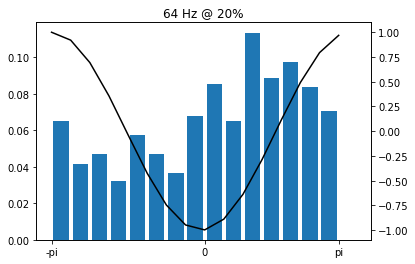

In [18]:
plot_osc_hist(data = spks_64Hz_soma_20p,
              f = 64,
              tsim = 150,
              n_bins = 16,
              title = '64 Hz @ 20%',
              multi = 1)

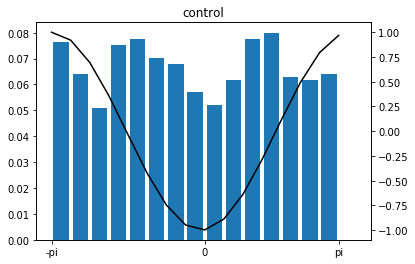

In [19]:
plot_osc_hist(data = spks_control,
              f = 64,
              tsim = 150,
              n_bins = 16,
              title = 'control',
              multi = 1)

## Na spikes

# Find em
### For 16 Hz dend inh

In [ ]:
output_folder = 'output_16Hz_dend_inh'

v = h5py.File('./{}/v_report.h5'.format(output_folder),'r')
hva = h5py.File('./{}/Ca_HVA.ica_report.h5'.format(output_folder),'r')
lva = h5py.File('./{}/Ca_LVAst.ica_report.h5'.format(output_folder),'r')
ih = h5py.File('./{}/Ih.ihcn_report.h5'.format(output_folder),'r')

nmda = h5py.File('./{}/inmda_report.h5'.format(output_folder),'r')

na = h5py.File('./{}/NaTa_t.gNaTa_t_report.h5'.format(output_folder),'r')
spks = h5py.File('./{}/spikes.h5'.format(output_folder),'r')

spktimes = spks['spikes']['biophysical']['timestamps'][:]
spkinds = np.sort((spktimes*10).astype(int))

In [20]:
na_df = pd.DataFrame(columns=['segmentID','na_lower_bound'])

for p in segs[(segs.Type=='dend')|(segs.Type=='apic')].index:
    print(p)
    threshold_crossings = np.diff(na['report']['biophysical']['data'][:,p] > 0.003, prepend=False)
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    # Only count if not within 2 ms after a somatic spike
    na_spks = [i for i in upward_crossings if ~np.any((i-spkinds>=-5) & (i-spkinds<50))]
    
    if len(na_spks)>0:
        na_df = na_df.append(pd.DataFrame({'segmentID':np.tile(p,len(na_spks)),
                                               'na_lower_bound':na_spks}))
    else:
        na_df = na_df.append(pd.DataFrame({'segmentID':p,
                                               'na_lower_bound':np.array([np.nan])}))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


2513
2514
2515
2516
2517
2518
2519
2520


In [21]:
na_df.to_csv('16Hz_dend_inh_na_df.csv')

### For 64 Hz soma inh

In [20]:
output_folder = 'output_64Hz_soma_inh_20p'

v = h5py.File('./{}/v_report.h5'.format(output_folder),'r')
hva = h5py.File('./{}/Ca_HVA.ica_report.h5'.format(output_folder),'r')
lva = h5py.File('./{}/Ca_LVAst.ica_report.h5'.format(output_folder),'r')
ih = h5py.File('./{}/Ih.ihcn_report.h5'.format(output_folder),'r')

nmda = h5py.File('./{}/inmda_report.h5'.format(output_folder),'r')

na = h5py.File('./{}/NaTa_t.gNaTa_t_report.h5'.format(output_folder),'r')
spks = h5py.File('./{}/spikes.h5'.format(output_folder),'r')

spktimes = spks['spikes']['biophysical']['timestamps'][:]
spkinds = np.sort((spktimes*10).astype(int))

In [21]:
na_df = pd.DataFrame(columns=['segmentID','na_lower_bound'])

for p in segs[(segs.Type=='dend')|(segs.Type=='apic')].index:
    print(p)
    threshold_crossings = np.diff(na['report']['biophysical']['data'][:,p] > 0.003, prepend=False)
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    # Only count if not within 2 ms after a somatic spike
    na_spks = [i for i in upward_crossings if ~np.any((i-spkinds>=-5) & (i-spkinds<50))]
    
    if len(na_spks)>0:
        na_df = na_df.append(pd.DataFrame({'segmentID':np.tile(p,len(na_spks)),
                                               'na_lower_bound':na_spks}))
    else:
        na_df = na_df.append(pd.DataFrame({'segmentID':p,
                                               'na_lower_bound':np.array([np.nan])}))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


2513
2514
2515
2516
2517
2518
2519
2520


In [23]:
na_df.to_csv('64Hz_20p_soma_inh_na_df.csv')

In [26]:
nmda_df = pd.DataFrame(columns=['segmentID','nmda_lower_bound', 'nmda_upper_bound', 'mag'])
for p in segs[(segs.Type=='dend')|(segs.Type=='apic')].index:
    print(p)
    legit_uc = voltage_criterion(data=v['report']['biophysical']['data'][:-10000,p],v_thresh=-40, time_thresh=260)[1]
    legit_dc = voltage_criterion(data=v['report']['biophysical']['data'][:-10000,p],v_thresh=-40, time_thresh=260)[-1]
    
    legit_uc_iso = legit_uc
    
    legit_dc_iso = legit_dc
    
    
    if (len(legit_uc_iso)!=0) & (np.min(nmda['report']['biophysical']['data'][:,p])!=0):
        bnds, sum_curr = current_criterion(legit_uc_iso=legit_uc_iso, 
                                           legit_dc_iso=legit_dc_iso, 
                                           p=p, 
                                           control_inmda=nmda['report']['biophysical']['data'])
        nmda_df = nmda_df.append(pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
                                               'nmda_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
                                               'nmda_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
                                               'mag':sum_curr}))
    
    else:
        nmda_df = nmda_df.append(pd.DataFrame({'segmentID':np.tile(p,1),
                                               'nmda_lower_bound':np.nan,
                                               'nmda_upper_bound':np.nan,
                                               'mag':np.nan}))
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074


In [27]:
nmda_df.to_csv('64Hz_20p_soma_inh_nmda_df.csv')

In [46]:
na_control = pd.read_csv('na_df.csv')
na_16Hz_dend = pd.read_csv('16Hz_dend_inh_na_df.csv')
na_64Hz_soma = pd.read_csv('64Hz_soma_inh_na_df.csv')

segs_na_df_control = segs.set_index('segmentID').join(na_control.set_index('segmentID')).reset_index()
segs_na_df_16Hzdend = segs.set_index('segmentID').join(na_16Hz_dend.set_index('segmentID')).reset_index()
segs_na_df_64Hzsoma = segs.set_index('segmentID').join(na_64Hz_soma.set_index('segmentID')).reset_index()

na_control_rate = (segs_na_df_control.groupby('segmentID')['na_lower_bound'].count()/150).reset_index()
na_16Hzdend_rate = (segs_na_df_16Hzdend.groupby('segmentID')['na_lower_bound'].count()/150).reset_index()
na_64Hzsoma_rate = (segs_na_df_64Hzsoma.groupby('segmentID')['na_lower_bound'].count()/150).reset_index()

na_control_rate = na_control_rate.set_index('segmentID').join(segs[['segmentID','Coord X','Coord Y']].set_index('segmentID')).reset_index()
na_16Hzdend_rate = na_16Hzdend_rate.set_index('segmentID').join(segs[['segmentID','Coord X','Coord Y']].set_index('segmentID')).reset_index()
na_64Hzsoma_rate = na_64Hzsoma_rate.set_index('segmentID').join(segs[['segmentID','Coord X','Coord Y']].set_index('segmentID')).reset_index()


In [50]:
na_control['na_lower_bound'].max(), na_16Hz_dend['na_lower_bound'].max(), na_64Hz_soma['na_lower_bound'].max()


(1499987.0, 299913.0, 1499986.0)

In [33]:
seg_na_df = na_control.groupby('segmentID')['na_lower_bound'].count().reset_index().rename(columns={'na_lower_bound':'num_na_spikes'})
segs_na_df = segs.set_index('segmentID').join(seg_na_df.set_index('segmentID'))
segs_na_df.loc[segs_na_df.num_na_spikes>1000,'num_na_spikes'] = 1000

In [34]:
def plot_morph(segs_na_df, color_field, save_fig = 'na_control.svg'):
    ax = plt.figure(figsize=(4,10))
    import matplotlib
    from matplotlib.colors import Normalize
    cmap = matplotlib.cm.get_cmap('jet')
    norm = matplotlib.colors.Normalize(vmin = 0, vmax = 5)
    
    for i in segs_na_df[segs_na_df.Type=='apic']['Sec ID'].unique():
        section = segs_na_df[(segs_na_df.Type=='apic')&(segs_na_df['Sec ID']==i)]
        for j in section.index.tolist()[:-1]:
            plt.plot(section.loc[j:j+1,'Coord X'],
                     section.loc[j:j+1,'Coord Y'],
                 color=cmap(norm(section.loc[j:j+1,color_field].mean()/150)),
                 linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
        
    for i in segs_na_df[segs_na_df.Type=='dend']['Sec ID'].unique():
        section = segs_na_df[(segs_na_df.Type=='dend')&(segs_na_df['Sec ID']==i)]
        for j in section.index.tolist()[:-1]:
            plt.plot(section.loc[j:j+1,'Coord X'],
                     section.loc[j:j+1,'Coord Y'],
                 color=cmap(norm(section.loc[j:j+1,color_field].mean()/150)),
                 linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
            
    plt.scatter(segs_na_df[(segs_na_df.Type=='soma')&(segs_na_df['Sec ID']==0)].loc[2,'Coord X'],
             segs_na_df[(segs_na_df.Type=='soma')&(segs_na_df['Sec ID']==0)].loc[2,'Coord Y'],color='k',s=100)
    plt.vlines(110,400,500)
    plt.text(0,450,'100 um')
    plt.hlines(400,110,210)
    plt.text(110,350,'100 um')
    plt.xticks([])
    plt.yticks([])
    cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
    #cbar.ax.set_ylabel('log(elec_distance)', rotation=270)
    
    #ax2.ax.set_title('log(elec_distance)',rotation=270)
    plt.box(False)
    plt.savefig(save_fig)

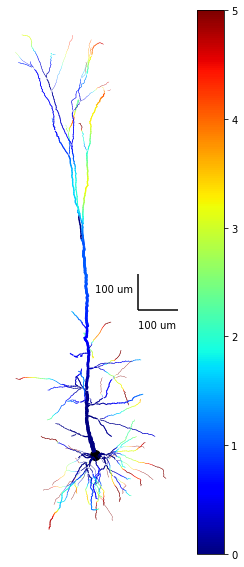

In [35]:
plot_morph(segs_na_df = segs_na_df, color_field = 'num_na_spikes', save_fig = 'na_control.svg')

In [38]:
seg_na_df_16Hz_dend = na_16Hz_dend.groupby('segmentID')['na_lower_bound'].count().reset_index().rename(columns={'na_lower_bound':'num_na_spikes'})
segs_na_df_16Hz_dend = segs.set_index('segmentID').join(seg_na_df_16Hz_dend.set_index('segmentID'))
segs_na_df_16Hz_dend.loc[segs_na_df_16Hz_dend.num_na_spikes>1000,'num_na_spikes'] = 1000

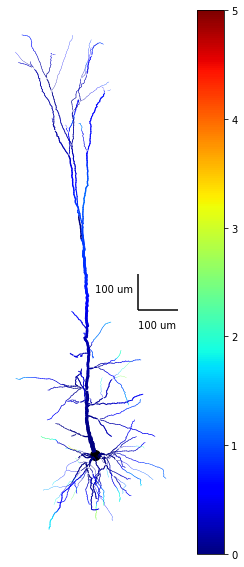

In [40]:
plot_morph(segs_na_df = segs_na_df_16Hz_dend, color_field = 'num_na_spikes', save_fig = 'na_16Hz_dend.svg')

In [44]:
seg_na_df_64Hz_soma = na_64Hz_soma.groupby('segmentID')['na_lower_bound'].count().reset_index().rename(columns={'na_lower_bound':'num_na_spikes'})
segs_na_df_64Hz_soma = segs.set_index('segmentID').join(seg_na_df_64Hz_soma.set_index('segmentID'))
segs_na_df_64Hz_soma.loc[segs_na_df_64Hz_soma.num_na_spikes>1000,'num_na_spikes'] = 1000

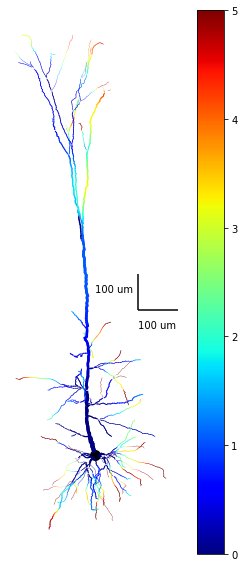

In [45]:
plot_morph(segs_na_df = segs_na_df_64Hz_soma, color_field = 'num_na_spikes', save_fig = 'na_64Hz_soma.svg')

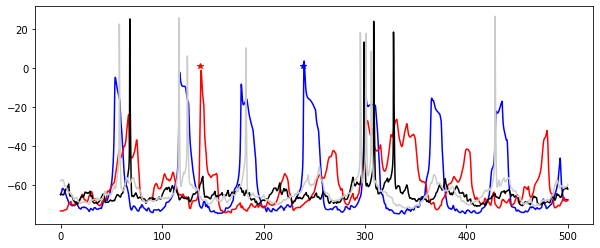

In [43]:
# Plot mem. potential at nexus to see what's going on there
plt.figure(figsize=(10,4))
tstart = 10000
tstop = 15000
events_control = na_control[(na_control.segmentID==1482)&
                            (na_control.na_lower_bound>tstart)&
                            (na_control.na_lower_bound<tstop)].copy()
events_16Hz = na_16Hz_dend[(na_16Hz_dend.segmentID==1482)&
                           (na_16Hz_dend.na_lower_bound>tstart)&
                           (na_16Hz_dend.na_lower_bound<tstop)].copy()
plt.plot(np.arange(0,(tstop-tstart)/10,.1),v_16Hz_dend['report']['biophysical']['data'][tstart:tstop,1482],color='b')
plt.plot(np.arange(0,(tstop-tstart)/10,.1),v_control['report']['biophysical']['data'][tstart:tstop,1482],color='r')
plt.plot(np.arange(0,(tstop-tstart)/10,.1),v_control['report']['biophysical']['data'][tstart:tstop,0],color='k')
plt.plot(np.arange(0,(tstop-tstart)/10,.1),v_16Hz_dend['report']['biophysical']['data'][tstart:tstop,0],color=[0.8,0.8,0.8])
plt.plot((events_16Hz['na_lower_bound']/10) - (tstart/10), np.ones((events_16Hz.shape[0],1)),'b*')
plt.plot((events_control['na_lower_bound']/10) - (tstart/10), np.ones((events_control.shape[0],1)),'r*')
plt.savefig('16Hz_rhythmic_v.svg')

In [2]:
import numpy as np
np.random.normal(1,1)

-0.186385681593481

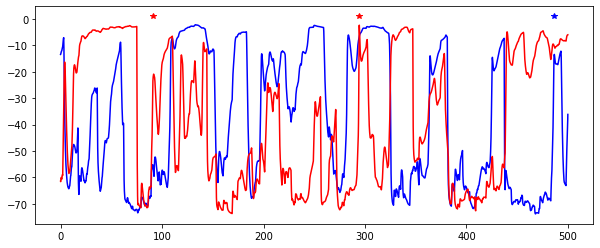

In [81]:
# mem.potential at distal apical
plt.figure(figsize=(10,4))
tstart = 10000
tstop = 15000
events_control = na_control[(na_control.segmentID==1800)&
                            (na_control.na_lower_bound>tstart)&
                            (na_control.na_lower_bound<tstop)].copy()
events_16Hz = na_16Hz_dend[(na_16Hz_dend.segmentID==1800)&
                           (na_16Hz_dend.na_lower_bound>tstart)&
                           (na_16Hz_dend.na_lower_bound<tstop)].copy()
plt.plot(np.arange(0,(tstop-tstart)/10,.1),v_16Hz_dend['report']['biophysical']['data'][tstart:tstop,1800],color='b')
plt.plot(np.arange(0,(tstop-tstart)/10,.1),v_control['report']['biophysical']['data'][tstart:tstop,1800],color='r')
#plt.plot(np.arange(0,(tstop-tstart)/10,.1),v_control['report']['biophysical']['data'][tstart:tstop,0],color='k')
#plt.plot(np.arange(0,(tstop-tstart)/10,.1),v_16Hz_dend['report']['biophysical']['data'][tstart:tstop,0],color=[0.8,0.8,0.8])
plt.plot((events_16Hz['na_lower_bound']/10) - (tstart/10), np.ones((events_16Hz.shape[0],1)),'b*')
plt.plot((events_control['na_lower_bound']/10) - (tstart/10), np.ones((events_control.shape[0],1)),'r*')
plt.savefig('16Hz_rhythmic_v.svg')

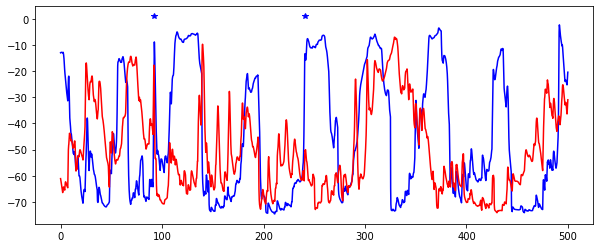

In [90]:
# mem.potential at oblique apical
plt.figure(figsize=(10,4))
tstart = 10000
tstop = 15000
events_control = na_control[(na_control.segmentID==1249)&
                            (na_control.na_lower_bound>tstart)&
                            (na_control.na_lower_bound<tstop)].copy()
events_16Hz = na_16Hz_dend[(na_16Hz_dend.segmentID==1249)&
                           (na_16Hz_dend.na_lower_bound>tstart)&
                           (na_16Hz_dend.na_lower_bound<tstop)].copy()
plt.plot(np.arange(0,(tstop-tstart)/10,.1),v_16Hz_dend['report']['biophysical']['data'][tstart:tstop,1249],color='b')
plt.plot(np.arange(0,(tstop-tstart)/10,.1),v_control['report']['biophysical']['data'][tstart:tstop,1249],color='r')
#plt.plot(np.arange(0,(tstop-tstart)/10,.1),v_control['report']['biophysical']['data'][tstart:tstop,0],color='k')
#plt.plot(np.arange(0,(tstop-tstart)/10,.1),v_16Hz_dend['report']['biophysical']['data'][tstart:tstop,0],color=[0.8,0.8,0.8])
plt.plot((events_16Hz['na_lower_bound']/10) - (tstart/10), np.ones((events_16Hz.shape[0],1)),'b*')
plt.plot((events_control['na_lower_bound']/10) - (tstart/10), np.ones((events_control.shape[0],1)),'r*')
plt.savefig('16Hz_rhythmic_v.svg')

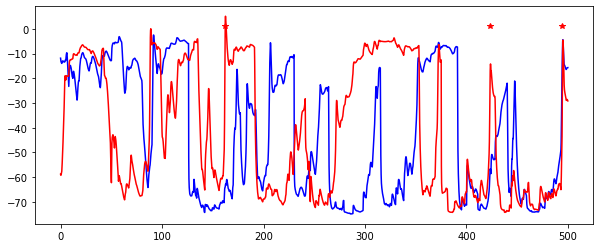

In [101]:
# mem.potential at basal
plt.figure(figsize=(10,4))
tstart = 10000
tstop = 15000
events_control = na_control[(na_control.segmentID==88)&
                            (na_control.na_lower_bound>tstart)&
                            (na_control.na_lower_bound<tstop)].copy()
events_16Hz = na_16Hz_dend[(na_16Hz_dend.segmentID==88)&
                           (na_16Hz_dend.na_lower_bound>tstart)&
                           (na_16Hz_dend.na_lower_bound<tstop)].copy()
plt.plot(np.arange(0,(tstop-tstart)/10,.1),v_16Hz_dend['report']['biophysical']['data'][tstart:tstop,88],color='b')
plt.plot(np.arange(0,(tstop-tstart)/10,.1),v_control['report']['biophysical']['data'][tstart:tstop,88],color='r')
#plt.plot(np.arange(0,(tstop-tstart)/10,.1),v_control['report']['biophysical']['data'][tstart:tstop,0],color='k')
#plt.plot(np.arange(0,(tstop-tstart)/10,.1),v_16Hz_dend['report']['biophysical']['data'][tstart:tstop,0],color=[0.8,0.8,0.8])
plt.plot((events_16Hz['na_lower_bound']/10) - (tstart/10), np.ones((events_16Hz.shape[0],1)),'b*')
plt.plot((events_control['na_lower_bound']/10) - (tstart/10), np.ones((events_control.shape[0],1)),'r*')
plt.savefig('16Hz_rhythmic_v.svg')

Text(0.5, 1.0, '64 Hz soma inh.')

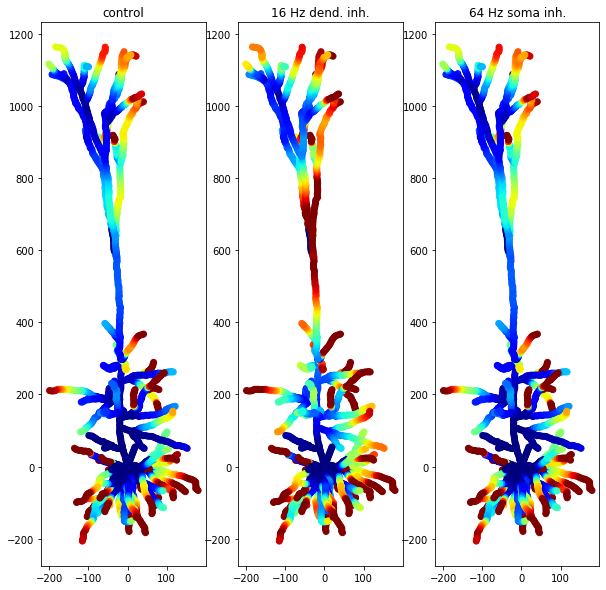

In [69]:
plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.scatter(na_control_rate['Coord X'], 
            na_control_rate['Coord Y'],
            c=na_control_rate['na_lower_bound'],
            vmin=0,
            vmax=5,
            cmap='jet')

plt.title('control')

plt.subplot(1,3,2)
plt.scatter(na_16Hzdend_rate['Coord X'], 
            na_16Hzdend_rate['Coord Y'],
            c=na_16Hzdend_rate['na_lower_bound'],
            vmin=0,
            vmax=5,
            cmap='jet')

plt.title('16 Hz dend. inh.')

plt.subplot(1,3,3)
plt.scatter(na_16Hzdend_rate['Coord X'], 
            na_16Hzdend_rate['Coord Y'],
            c=na_64Hzsoma_rate['na_lower_bound'],
            vmin=0,
            vmax=5,
            cmap='jet')

plt.title('64 Hz soma inh.')

## NMDA spikes

In [71]:
nmda_control = pd.read_csv('nmda_df.csv')
nmda_16Hz_dend = pd.read_csv('16Hz_dend_inh_nmda_df.csv')
nmda_64Hz_soma = pd.read_csv('64Hz_soma_inh_nmda_df.csv')

segs_nmda_df_control = segs.set_index('segmentID').join(nmda_control.set_index('segmentID')).reset_index()
segs_nmda_df_16Hzdend = segs.set_index('segmentID').join(nmda_16Hz_dend.set_index('segmentID')).reset_index()
segs_nmda_df_64Hzsoma = segs.set_index('segmentID').join(nmda_64Hz_soma.set_index('segmentID')).reset_index()

nmda_control_rate = (segs_nmda_df_control.groupby('segmentID')['nmda_lower_bound'].count()/150).reset_index()
nmda_16Hzdend_rate = (segs_nmda_df_16Hzdend.groupby('segmentID')['nmda_lower_bound'].count()/150).reset_index()
nmda_64Hzsoma_rate = (segs_nmda_df_64Hzsoma.groupby('segmentID')['nmda_lower_bound'].count()/150).reset_index()

nmda_control_rate = nmda_control_rate.set_index('segmentID').join(segs[['segmentID','Coord X','Coord Y']].set_index('segmentID')).reset_index()
nmda_16Hzdend_rate = nmda_16Hzdend_rate.set_index('segmentID').join(segs[['segmentID','Coord X','Coord Y']].set_index('segmentID')).reset_index()
nmda_64Hzsoma_rate = nmda_64Hzsoma_rate.set_index('segmentID').join(segs[['segmentID','Coord X','Coord Y']].set_index('segmentID')).reset_index()


Text(0.5, 1.0, '64 Hz soma inh.')

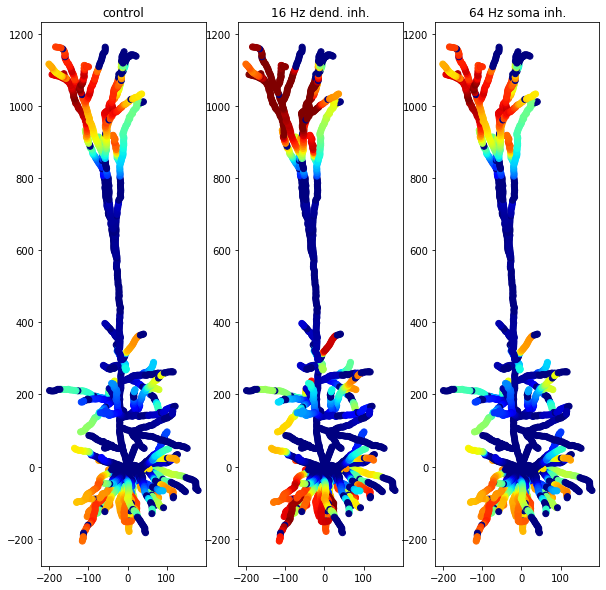

In [73]:
plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.scatter(nmda_control_rate['Coord X'], 
            nmda_control_rate['Coord Y'],
            c=nmda_control_rate['nmda_lower_bound'],
            vmin=0,
            vmax=10,
            cmap='jet')

plt.title('control')

plt.subplot(1,3,2)
plt.scatter(nmda_16Hzdend_rate['Coord X'], 
            nmda_16Hzdend_rate['Coord Y'],
            c=nmda_16Hzdend_rate['nmda_lower_bound'],
            vmin=0,
            vmax=10,
            cmap='jet')

plt.title('16 Hz dend. inh.')

plt.subplot(1,3,3)
plt.scatter(nmda_16Hzdend_rate['Coord X'], 
            nmda_16Hzdend_rate['Coord Y'],
            c=nmda_64Hzsoma_rate['nmda_lower_bound'],
            vmin=0,
            vmax=10,
            cmap='jet')

plt.title('64 Hz soma inh.')

## Ca spikes

In [76]:
ca_control = pd.read_csv('ca_df.csv')
ca_16Hz_dend = pd.read_csv('16Hz_dend_inh_ca_df.csv')
ca_64Hz_soma = pd.read_csv('64Hz_soma_inh_ca_df.csv')

segs_ca_df_control = segs.set_index('segmentID').join(ca_control.set_index('segmentID')).reset_index()
segs_ca_df_16Hzdend = segs.set_index('segmentID').join(ca_16Hz_dend.set_index('segmentID')).reset_index()
segs_ca_df_64Hzsoma = segs.set_index('segmentID').join(ca_64Hz_soma.set_index('segmentID')).reset_index()

ca_control_rate = (segs_ca_df_control.groupby('segmentID')['ca_lower_bound'].count()/150).reset_index()
ca_16Hzdend_rate = (segs_ca_df_16Hzdend.groupby('segmentID')['ca_lower_bound'].count()/150).reset_index()
ca_64Hzsoma_rate = (segs_ca_df_64Hzsoma.groupby('segmentID')['ca_lower_bound'].count()/150).reset_index()

ca_control_rate = ca_control_rate.set_index('segmentID').join(segs[['segmentID','Coord X','Coord Y']].set_index('segmentID')).reset_index()
ca_16Hzdend_rate = ca_16Hzdend_rate.set_index('segmentID').join(segs[['segmentID','Coord X','Coord Y']].set_index('segmentID')).reset_index()
ca_64Hzsoma_rate = ca_64Hzsoma_rate.set_index('segmentID').join(segs[['segmentID','Coord X','Coord Y']].set_index('segmentID')).reset_index()


Text(0.5, 1.0, '64 Hz soma inh.')

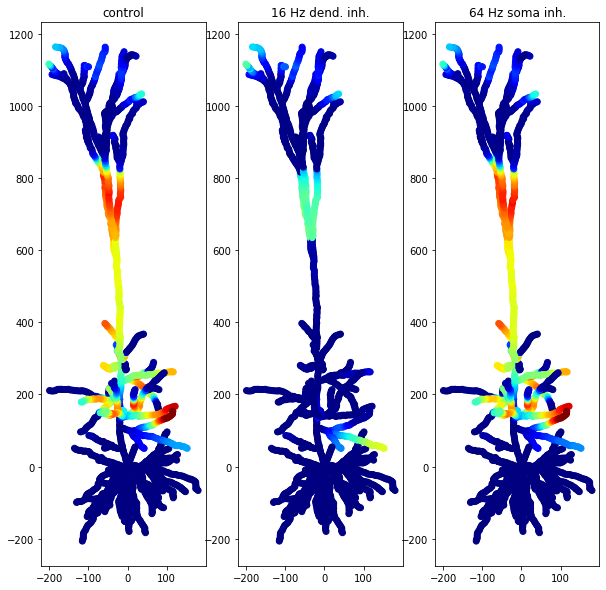

In [79]:
plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.scatter(ca_control_rate['Coord X'], 
            ca_control_rate['Coord Y'],
            c=ca_control_rate['ca_lower_bound'],
            vmin=0,
            vmax=5,
            cmap='jet')

plt.title('control')

plt.subplot(1,3,2)
plt.scatter(ca_16Hzdend_rate['Coord X'], 
            ca_16Hzdend_rate['Coord Y'],
            c=ca_16Hzdend_rate['ca_lower_bound'],
            vmin=0,
            vmax=5,
            cmap='jet')

plt.title('16 Hz dend. inh.')

plt.subplot(1,3,3)
plt.scatter(ca_16Hzdend_rate['Coord X'], 
            ca_16Hzdend_rate['Coord Y'],
            c=ca_64Hzsoma_rate['ca_lower_bound'],
            vmin=0,
            vmax=5,
            cmap='jet')

plt.title('64 Hz soma inh.')

## Do spikes that occur in the trough of oscillation have the same dependence on Na and NMDA spikes as the spikes in the peak?

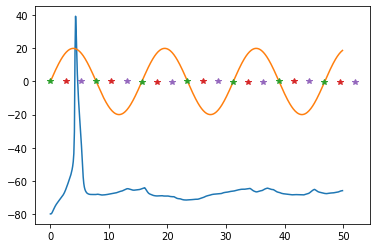

In [26]:
plt.plot(np.arange(0,50,.1),v_64Hz_soma_50p['report']['biophysical']['data'][0:500,0])
plt.plot(np.arange(0,50,.1), 20*np.sin(2*np.pi*(64/1000)*np.arange(0,50,.1)))
zero_crossings = np.where(np.diff(np.sign(20*np.sin(2*np.pi*(64/1000)*np.arange(0,50,.1)))))[0]
plt.plot(zero_crossings/10,20*np.sin(2*np.pi*(64/1000)*np.arange(0,50,.1))[zero_crossings],'*')
plt.plot(2.6+zero_crossings/10,20*np.sin(2*np.pi*(64/1000)*np.arange(0,50,.1))[zero_crossings],'*')
plt.plot(5.2+zero_crossings/10,20*np.sin(2*np.pi*(64/1000)*np.arange(0,50,.1))[zero_crossings],'*')

In [41]:
spktimes = np.sort(spks_64Hz_soma_50p['spikes']['biophysical']['timestamps'][:])

In [73]:
# calculates the phase in percentage of a wavelength
# 0.25 is at the peak (pi/2), 0.75 is at the trough (3pi/2)
(np.mod(spktimes,(1000/64)))/(1000/64)

array([2.75200000e-01, 8.84800000e-01, 9.79200000e-01, 9.76000000e-02,
       1.28000000e-01, 8.86400000e-01, 5.28000000e-02, 7.82400000e-01,
       8.00000000e-01, 8.43200000e-01, 8.32000000e-01, 1.39200000e-01,
       5.59999999e-02, 1.34400000e-01, 2.30400000e-01, 1.21600000e-01,
       2.36800000e-01, 7.74400000e-01, 2.54400000e-01, 8.73600000e-01,
       1.26400000e-01, 8.32000001e-02, 1.50400000e-01, 1.36000000e-01,
       1.82400000e-01, 6.56000000e-01, 5.92000004e-02, 6.88000004e-02,
       9.15200000e-01, 7.98400000e-01, 2.97600000e-01, 4.16000004e-02,
       9.85600000e-01, 6.08000005e-02, 9.95200001e-01, 7.50400001e-01,
       3.64800001e-01, 1.04000001e-01, 8.27200001e-01, 7.20000007e-02,
       8.84800001e-01, 5.92000010e-02, 1.32800001e-01, 9.02400001e-01,
       7.24800001e-01, 1.10400001e-01, 9.23200001e-01, 1.76000011e-02,
       1.14797149e-09, 9.47200001e-01, 7.04000012e-02, 4.80000130e-03,
       2.24000013e-02, 2.24000001e-01, 9.71200001e-01, 9.44000012e-02,
      

(array([219., 139.,  64.,  24.,   7.,  13.,  18.,  43., 129., 222.]),
 array([1.14797149e-09, 9.98400308e-02, 1.99680061e-01, 2.99520090e-01,
        3.99360120e-01, 4.99200150e-01, 5.99040179e-01, 6.98880209e-01,
        7.98720239e-01, 8.98560268e-01, 9.98400298e-01]),
 <a list of 10 Patch objects>)

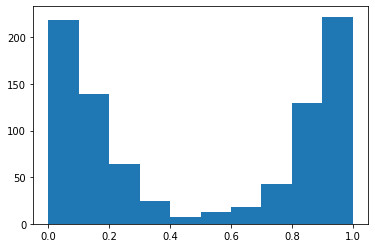

In [72]:
plt.hist((np.mod(spktimes,(1000/64)))/(1000/64))

## Na spikes

In [34]:
def get_sta(segs_na_df, spktimes):
    na_dend = np.zeros((10,39,))
    na_apic = np.zeros((10,39,))
    
    edges_dend=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='dend')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    edges_apic=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='dend')&
                                     (segs_na_df.Elec_distance>edges_dend[e])&
                                     (segs_na_df.Elec_distance<=edges_dend[e+1])]['na_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_dend[e] += x2
                
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='apic')&
                                     (segs_na_df.Elec_distance>edges_apic[e])&
                                     (segs_na_df.Elec_distance<=edges_apic[e+1])]['na_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
    return na_dend, na_apic

In [35]:
na_df = pd.read_csv('64Hz_20p_soma_inh_na_df.csv')
segs_na_df = segs.set_index('segmentID').join(na_df.set_index('segmentID')).reset_index()

In [46]:
spktimes = np.sort(spks_64Hz_soma_20p['spikes']['biophysical']['timestamps'][:])

phase_calc = (np.mod(spktimes,(1000/64)))/(1000/64)

### 7pi/4 to pi/4 ###
spikes = spktimes[(phase_calc>=0.875) | (phase_calc<0.125)]

na_dend, na_apic = get_sta(segs_na_df, spikes)

rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spikes.shape[0]))
na_dend_rand, na_apic_rand = get_sta(segs_na_df, rand_spktimes)

matrix1_apic = (na_apic-na_apic_rand)/len(spikes)
matrix1_basal = (na_dend-na_dend_rand)/len(spikes)

print('matrix1 complete. num spikes: {}'.format(spikes.shape[0]))

### pi/4 to 3pi/4 ###
spikes = spktimes[(phase_calc>=0.125) & (phase_calc<0.375)]

na_dend, na_apic = get_sta(segs_na_df, spikes)

rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spikes.shape[0]))
na_dend_rand, na_apic_rand = get_sta(segs_na_df, rand_spktimes)

matrix2_apic = (na_apic-na_apic_rand)/len(spikes)
matrix2_basal = (na_dend-na_dend_rand)/len(spikes)

print('matrix2 complete. num spikes: {}'.format(spikes.shape[0]))

###3pi/4 to 5pi/4###
spikes = spktimes[(phase_calc>=0.375) & (phase_calc<0.625)]

na_dend, na_apic = get_sta(segs_na_df, spikes)

rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spikes.shape[0]))
na_dend_rand, na_apic_rand = get_sta(segs_na_df, rand_spktimes)

matrix3_apic = (na_apic-na_apic_rand)/len(spikes)
matrix3_basal = (na_dend-na_dend_rand)/len(spikes)

print('matrix3 complete. num spikes: {}'.format(spikes.shape[0]))

### 5pi/4 to 7pi/4 ###
spikes = spktimes[(phase_calc>=0.625) & (phase_calc<=0.875)]

na_dend, na_apic = get_sta(segs_na_df, spikes)

rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spikes.shape[0]))
na_dend_rand, na_apic_rand = get_sta(segs_na_df, rand_spktimes)

matrix4_apic = (na_apic-na_apic_rand)/len(spikes)
matrix4_basal = (na_dend-na_dend_rand)/len(spikes)

print('matrix4 complete. num spikes: {}'.format(spikes.shape[0]))

matrix1 complete. num spikes: 239
matrix2 complete. num spikes: 166
matrix3 complete. num spikes: 117
matrix4 complete. num spikes: 156


In [47]:
239+166+117+156

678

In [48]:
spktimes.shape[0]

678

In [63]:
apic_na = np.array([matrix1_apic, matrix2_apic, matrix3_apic, matrix4_apic])
basal_na = np.array([matrix1_basal, matrix2_basal, matrix3_basal, matrix4_basal])

np.save('apical_na.npy',apic_na)
np.save('basal_na.npy',basal_na)

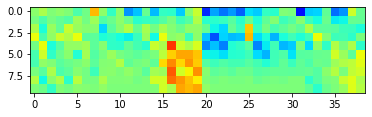

In [62]:
plt.imshow(apic_na[0],cmap='jet',vmin=-1,vmax=1)

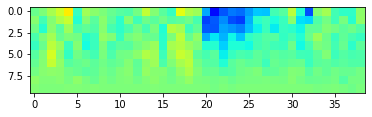

In [64]:
plt.imshow(basal_na[0],cmap='jet',vmin=-1,vmax=1)

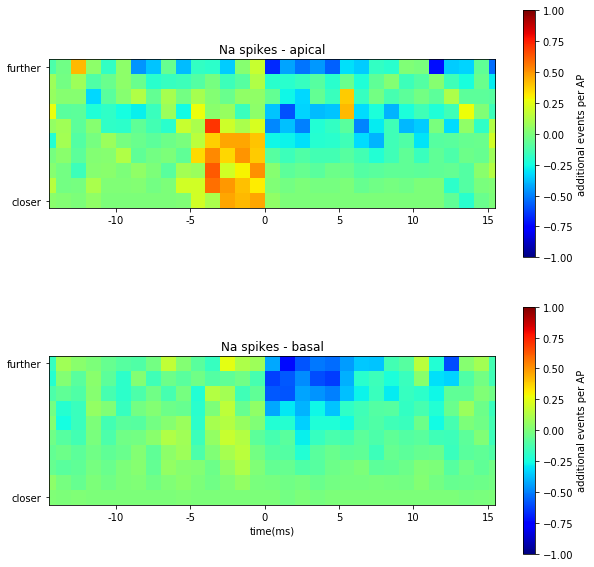

In [49]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Na spikes - apical')
plt.imshow(matrix1_apic,cmap='jet',vmin=-1,vmax=1)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlim(5,35)

plt.subplot(2,1,2)
plt.title('Na spikes - basal')
plt.imshow(matrix1_basal,cmap='jet',vmin=-1,vmax=1)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlabel('time(ms)')
plt.xlim(5,35)

plt.show()

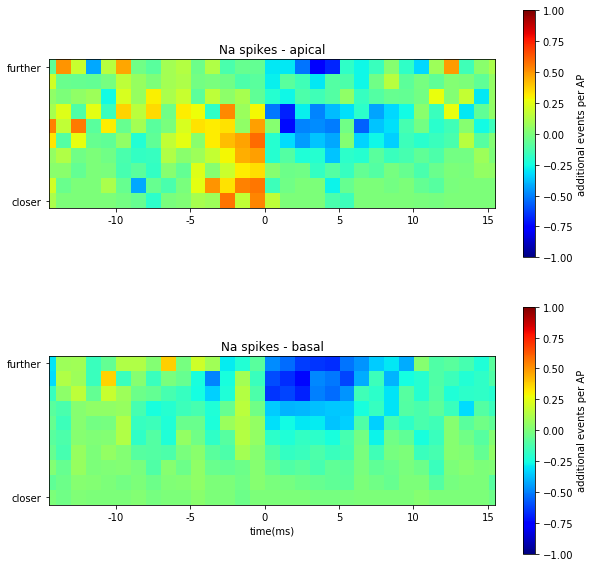

In [50]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Na spikes - apical')
plt.imshow(matrix2_apic,cmap='jet',vmin=-1,vmax=1)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlim(5,35)

plt.subplot(2,1,2)
plt.title('Na spikes - basal')
plt.imshow(matrix2_basal,cmap='jet',vmin=-1,vmax=1)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlabel('time(ms)')
plt.xlim(5,35)

plt.show()

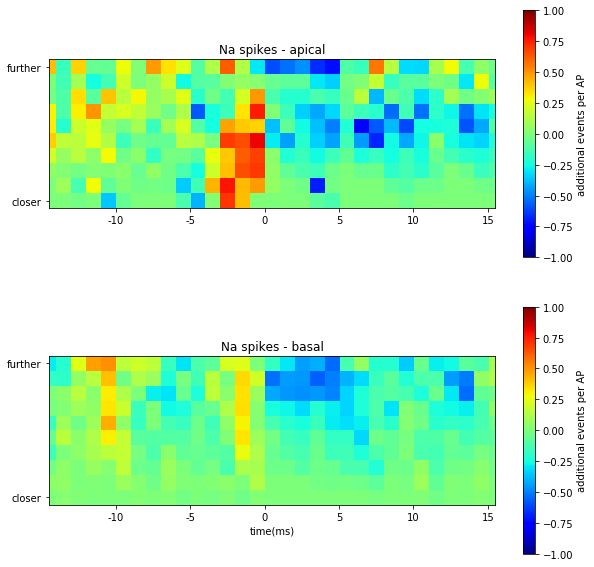

In [51]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Na spikes - apical')
plt.imshow(matrix3_apic,cmap='jet',vmin=-1,vmax=1)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlim(5,35)

plt.subplot(2,1,2)
plt.title('Na spikes - basal')
plt.imshow(matrix3_basal,cmap='jet',vmin=-1,vmax=1)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlabel('time(ms)')
plt.xlim(5,35)

plt.show()

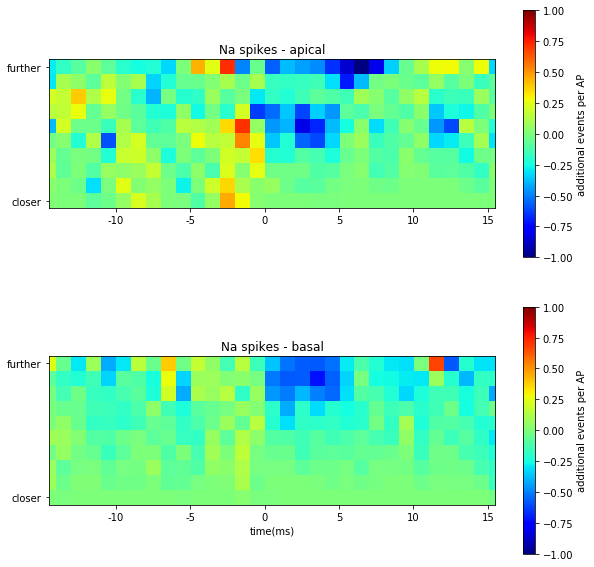

In [52]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Na spikes - apical')
plt.imshow(matrix4_apic,cmap='jet',vmin=-1,vmax=1)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlim(5,35)

plt.subplot(2,1,2)
plt.title('Na spikes - basal')
plt.imshow(matrix4_basal,cmap='jet',vmin=-1,vmax=1)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlabel('time(ms)')
plt.xlim(5,35)

plt.show()

## NMDA spikes - somatic

In [8]:
def get_nmda_sta(segs_nmda_df, spktimes):    
    nmda_dend = np.zeros((10,27,))
    nmda_apic = np.zeros((10,27,))
    
    edges_dend=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                   (segs_nmda_df.Type=='dend')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    edges_apic=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                   (segs_nmda_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                     (segs_nmda_df.Type=='dend')&
                                     (segs_nmda_df.Elec_distance>edges_dend[e])&
                                     (segs_nmda_df.Elec_distance<=edges_dend[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_dend[e] += x2
                
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                     (segs_nmda_df.Type=='apic')&
                                     (segs_nmda_df.Elec_distance>edges_apic[e])&
                                     (segs_nmda_df.Elec_distance<=edges_apic[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
        
    return nmda_dend, nmda_apic

In [9]:
nmda_df = pd.read_csv('64Hz_20p_soma_inh_nmda_df.csv')
nmda_df.rename(columns={'seg_id':'segmentID'},inplace=True)
segs_nmda_df = segs.set_index('segmentID').join(nmda_df.set_index('segmentID')).reset_index()

In [10]:
spktimes = np.sort(spks_64Hz_soma_20p['spikes']['biophysical']['timestamps'][:])

phase_calc = (np.mod(spktimes,(1000/64)))/(1000/64)

### 7pi/4 to pi/4 ###
spikes = spktimes[(phase_calc>=0.875) | (phase_calc<0.125)]

na_dend, na_apic = get_nmda_sta(segs_nmda_df, spikes)

rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spikes.shape[0]))
na_dend_rand, na_apic_rand = get_nmda_sta(segs_nmda_df, rand_spktimes)

matrix1_apic = (na_apic-na_apic_rand)/len(spikes)
matrix1_basal = (na_dend-na_dend_rand)/len(spikes)

print('matrix1 complete. num spikes: {}'.format(spikes.shape[0]))

### pi/4 to 3pi/4 ###
spikes = spktimes[(phase_calc>=0.125) & (phase_calc<0.375)]

na_dend, na_apic = get_nmda_sta(segs_nmda_df, spikes)

rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spikes.shape[0]))
na_dend_rand, na_apic_rand = get_nmda_sta(segs_nmda_df, rand_spktimes)

matrix2_apic = (na_apic-na_apic_rand)/len(spikes)
matrix2_basal = (na_dend-na_dend_rand)/len(spikes)

print('matrix2 complete. num spikes: {}'.format(spikes.shape[0]))

###3pi/4 to 5pi/4###
spikes = spktimes[(phase_calc>=0.375) & (phase_calc<0.625)]

na_dend, na_apic = get_nmda_sta(segs_nmda_df, spikes)

rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spikes.shape[0]))
na_dend_rand, na_apic_rand = get_nmda_sta(segs_nmda_df, rand_spktimes)

matrix3_apic = (na_apic-na_apic_rand)/len(spikes)
matrix3_basal = (na_dend-na_dend_rand)/len(spikes)

print('matrix3 complete. num spikes: {}'.format(spikes.shape[0]))

### 5pi/4 to 7pi/4 ###
spikes = spktimes[(phase_calc>=0.625) & (phase_calc<=0.875)]

na_dend, na_apic = get_nmda_sta(segs_nmda_df, spikes)

rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spikes.shape[0]))
na_dend_rand, na_apic_rand = get_nmda_sta(segs_nmda_df, rand_spktimes)

matrix4_apic = (na_apic-na_apic_rand)/len(spikes)
matrix4_basal = (na_dend-na_dend_rand)/len(spikes)

print('matrix4 complete. num spikes: {}'.format(spikes.shape[0]))

matrix1 complete. num spikes: 239
matrix2 complete. num spikes: 166
matrix3 complete. num spikes: 117
matrix4 complete. num spikes: 156


In [73]:
239+166+117+156

678

In [74]:
spktimes.shape[0]

678

In [15]:
apic_nmda = np.array([matrix1_apic, matrix2_apic, matrix3_apic, matrix4_apic])
basal_nmda = np.array([matrix1_basal, matrix2_basal, matrix3_basal, matrix4_basal])

np.save('apical_nmda.npy',apic_nmda)
np.save('basal_nmda.npy',basal_nmda)

In [16]:
apic_nmda.shape

(4, 10, 27)

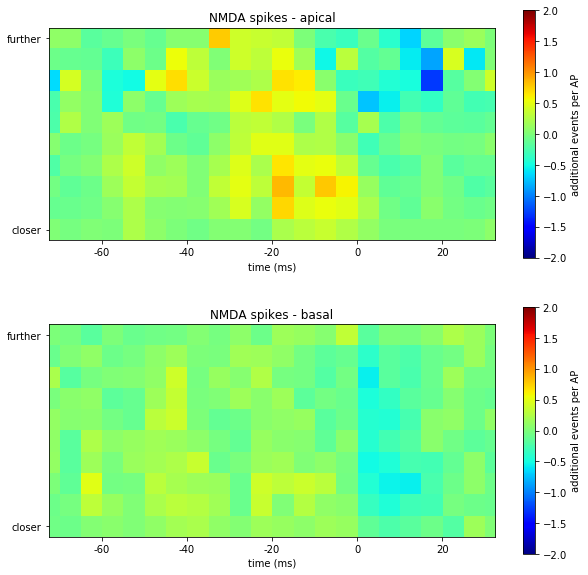

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow(matrix1_apic,cmap='jet',vmin=-2,vmax=2)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow(matrix1_basal,cmap='jet', vmin=-2, vmax=2)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.show()

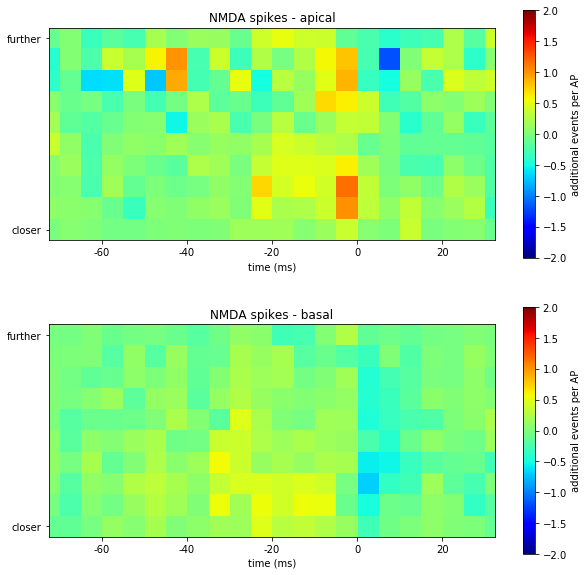

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow(matrix2_apic,cmap='jet',vmin=-2,vmax=2)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow(matrix2_basal,cmap='jet', vmin=-2, vmax=2)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.show()

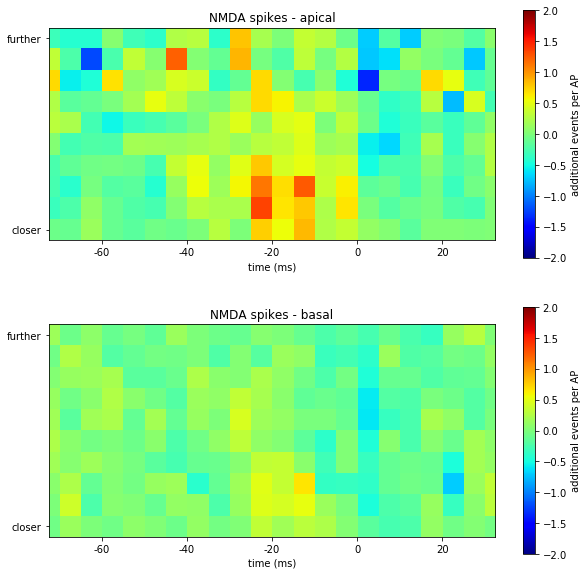

In [13]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow(matrix3_apic,cmap='jet',vmin=-2,vmax=2)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow(matrix3_basal,cmap='jet', vmin=-2, vmax=2)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.show()

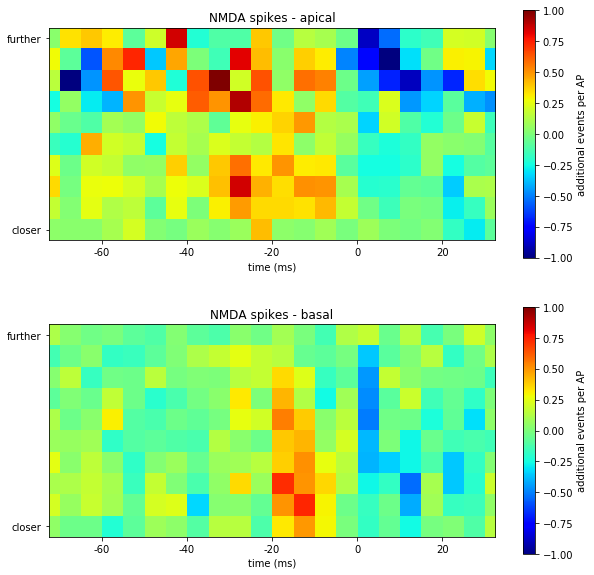

In [14]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow(matrix4_apic,cmap='jet',vmin=-1,vmax=1)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow(matrix4_basal,cmap='jet', vmin=-1, vmax=1)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.show()

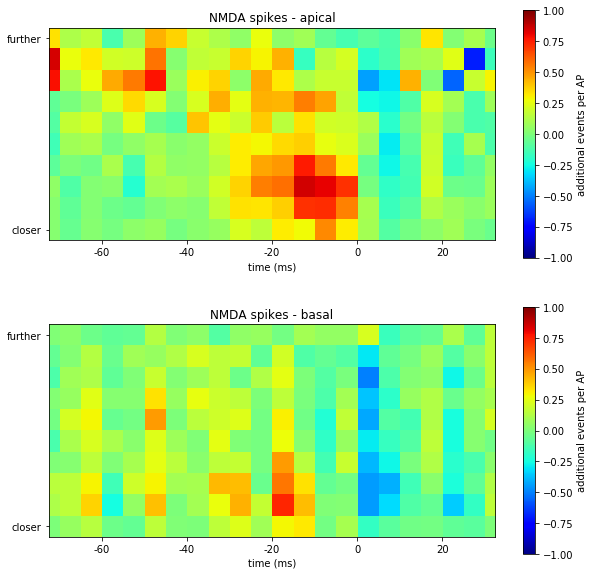

In [200]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow((nmda_apic_peak-nmda_apic_rand)/len(trough_spikes),cmap='jet',vmin=-1,vmax=1)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow((nmda_dend_peak-nmda_dend_rand)/len(trough_spikes),cmap='jet', vmin=-1, vmax=1)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.show()

In [195]:
nmda_dend_trough, nmda_apic_trough = get_nmda_sta(segs_nmda_df, trough_spikes)
nmda_dend_rand, nmda_apic_rand = get_nmda_sta(segs_nmda_df, rand_spktimes)

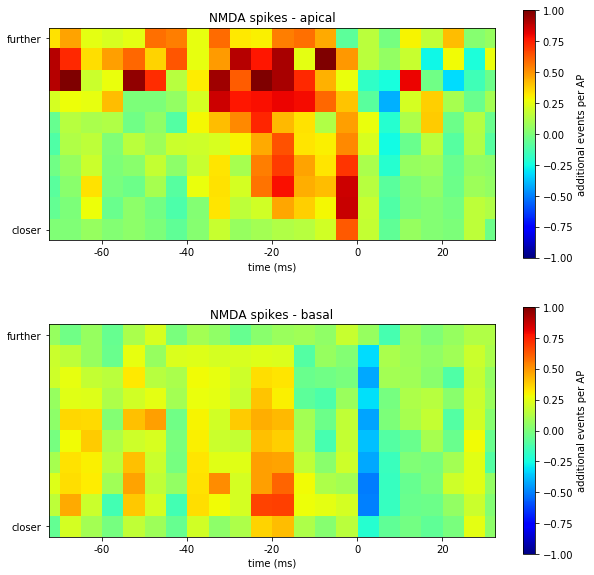

In [199]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow((nmda_apic_trough-nmda_apic_rand)/len(trough_spikes),cmap='jet',vmin=-1,vmax=1)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow((nmda_dend_trough-nmda_dend_rand)/len(trough_spikes),cmap='jet', vmin=-1, vmax=1)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.show()

## NMDA spikes - dendritic

In [202]:
spktimes = spks_16Hz_dend['spikes']['biophysical']['timestamps'][:]

peak_spikes = []
trough_spikes = []
for i in np.arange(0,zero_crossings.shape[0]-1):
    inds = np.where((spktimes>zero_crossings[i]/10)&
                    (spktimes<zero_crossings[i+1]/10))[0]
    if inds.shape[0]!=0:
        # For even i, append to peaks
        if np.mod(i,2)==0:
            peak_spikes.append(spktimes[inds][0])
        else:
            trough_spikes.append(spktimes[inds][0])
            
peak_spikes = np.array(peak_spikes)
trough_spikes = np.array(trough_spikes)

In [203]:
nmda_df = pd.read_csv('16Hz_dend_inh_nmda_df.csv')
nmda_df.rename(columns={'seg_id':'segmentID'},inplace=True)
segs_nmda_df = segs.set_index('segmentID').join(nmda_df.set_index('segmentID')).reset_index()

In [205]:
nmda_dend_peak, nmda_apic_peak = get_nmda_sta(segs_nmda_df, peak_spikes)
nmda_dend_rand, nmda_apic_rand = get_nmda_sta(segs_nmda_df, rand_spktimes)

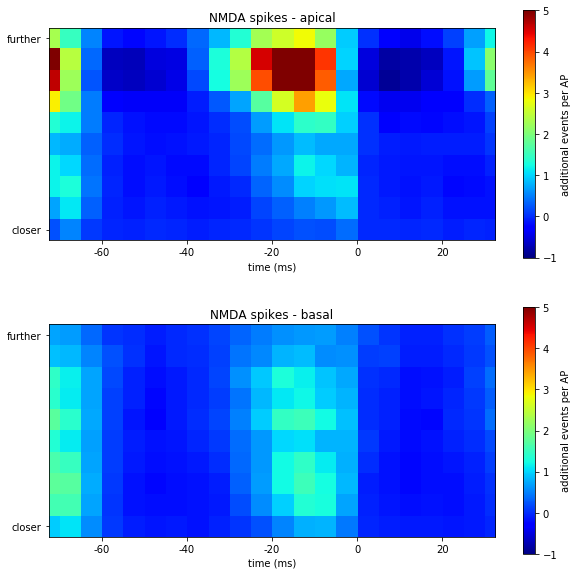

In [210]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow((nmda_apic_peak-nmda_apic_rand)/len(peak_spikes),cmap='jet',vmin=-1,vmax=5)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow((nmda_dend_peak-nmda_dend_rand)/len(peak_spikes),cmap='jet', vmin=-1, vmax=5)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.show()

In [207]:
nmda_dend_trough, nmda_apic_trough = get_nmda_sta(segs_nmda_df, trough_spikes)
nmda_dend_rand, nmda_apic_rand = get_nmda_sta(segs_nmda_df, rand_spktimes)

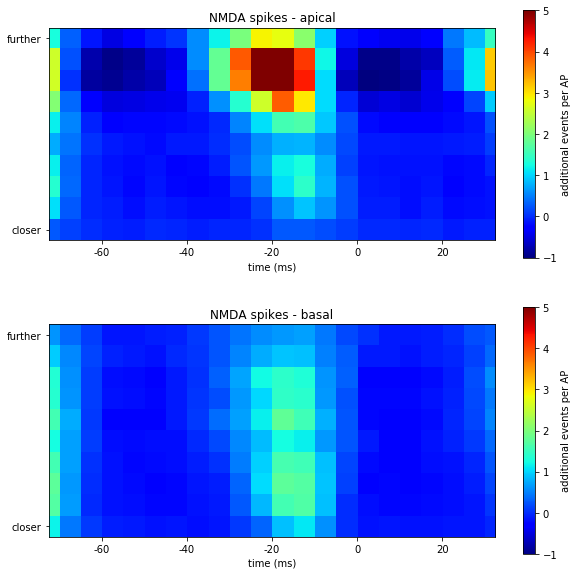

In [209]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow((nmda_apic_trough-nmda_apic_rand)/len(trough_spikes),cmap='jet',vmin=-1,vmax=5)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow((nmda_dend_trough-nmda_dend_rand)/len(trough_spikes),cmap='jet', vmin=-1, vmax=5)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.show()